In [1]:
# Import Required Libraries
import os, math

import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
import numpy as np
from scipy.stats import kurtosis
from scipy.signal import hilbert
from scipy.fft import fft
from scipy.signal import lfilter, butter
from scipy import io

from Functions.AR_filter import ar_filter

In [2]:
## 1. Signal Separation: AR filter
plt.rc('font', size=11)
os.chdir('Data_repository/KAU_bearing')                                         # Input data folder directory
x = np.ravel(io.loadmat('bearing1.mat')['vib']); N = len(x)                     # Load data
fs = 51.2e3; t = np.arange(0,N)/fs; fr = 1200/60                                # Sampling frequency(Hz), time vector(s), rotating frequency(Hz)
bff = np.array([4.4423, 6.5577, 0.4038, 5.0079])*fr                             # Bearing fault frequencies [BPFO BPFI FTF BSF]
xr, p = ar_filter(x, 700)                                                       # AR filtering
k1 = kurtosis(x, fisher=False); k2 = kurtosis(xr, fisher=False) 

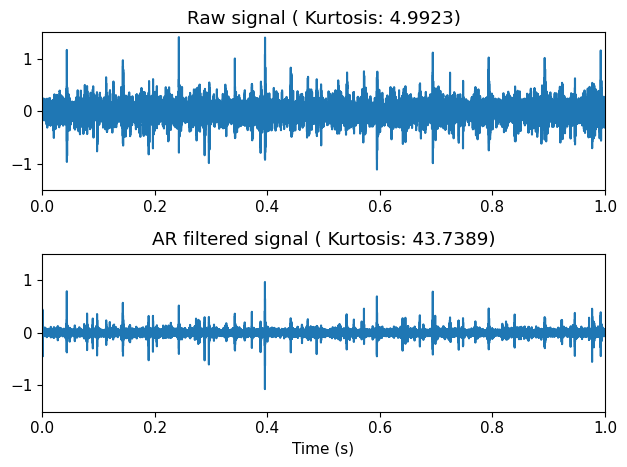

In [3]:
# Time domain signal
plt.figure(1)
plt.subplot(211); plt.plot(t, x); plt.xlim(0, 1); plt.ylim(-1.5,1.5)
plt.title(f'Raw signal ( Kurtosis: {k1:.4f})')
plt.subplot(212); plt.plot(t, xr); plt.xlim(0, 1); plt.ylim(-1.5,1.5)
plt.title(f'AR filtered signal ( Kurtosis: {k2:.4f})')
plt.xlabel('Time (s)')
plt.tight_layout()

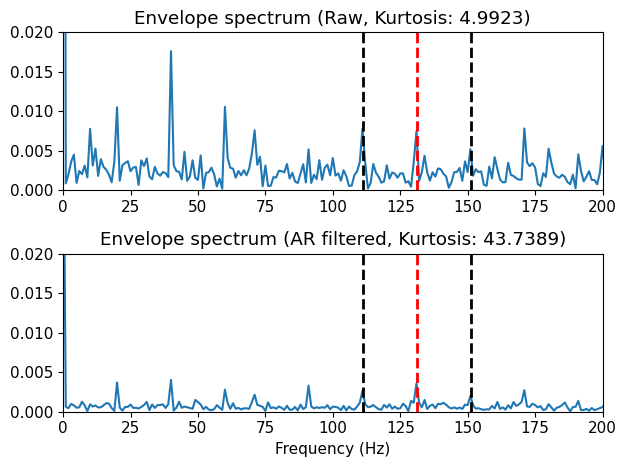

In [4]:
# Frequency domain signal
f = np.arange(0,N)/N*fs; f = f[0:math.ceil(N/2)]
X1 = np.abs(fft(abs(hilbert(x))))/N; X1 = X1[0:math.ceil(N/2)]
X2 = np.abs(fft(abs(hilbert(xr))))/N; X2 = X2[0:math.ceil(N/2)]
plt.figure(2)
plt.subplot(211); plt.plot(f, X1); plt.xlim(0, 200); plt.ylim(0, 0.02)
plt.title(f'Envelope spectrum (Raw, Kurtosis: {k1:.4f})')
plt.axvline(bff[1]-fr, c='k', ls='--', linewidth=2); plt.axvline(bff[1], c='r', ls='--', linewidth=2)
plt.axvline(bff[1]+fr, c='k', ls='--', linewidth=2)
plt.subplot(212); plt.plot(f, X2); plt.xlim(0, 200); plt.ylim(0, 0.02)
plt.title(f'Envelope spectrum (AR filtered, Kurtosis: {k2:.4f})')
plt.axvline(bff[1]-fr, c='k', ls='--', linewidth=2); plt.axvline(bff[1], c='r', ls='--', linewidth=2)
plt.axvline(bff[1]+fr, c='k', ls='--', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [5]:
## 2. Signal Enhancement: Spectral kurtosis
from Functions.Skbp import fast_kurtogram
k = kurtosis(x, fisher=False)

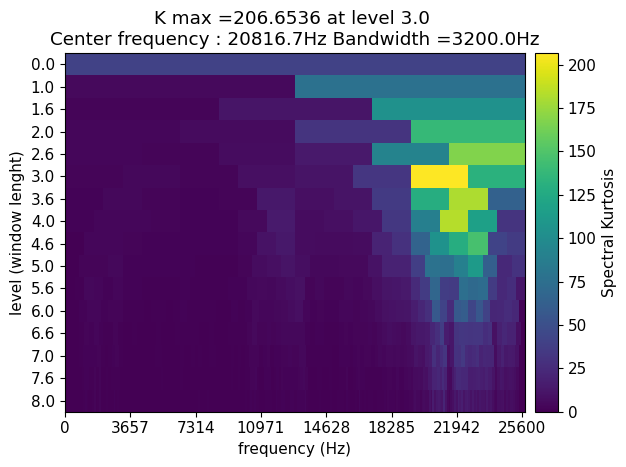

In [6]:
# Kurtogram <Figure 5(a)>
Kwav, Level_w, freq_w, c, max_Kurt, bandwidth, level_max = fast_kurtogram(xr, fs, nlevel=8)     # Center frequency & bandwidth obtained from kurtogram
minw = np.where(Level_w == level_max)[0][0]
kurtw = np.where(Kwav[minw, :] == max_Kurt)[0][0]
bandw = freq_w[kurtw]
ax = plt.gca()
im = ax.imshow(Kwav, interpolation='none', aspect='auto')
xlavel = np.array(np.arange(0, fs/2+fs/2/7, fs/2/7), dtype=int)
plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
plt.title(f'K max ={max_Kurt:.4f} at level {level_max:.1f} '
          f'\nCenter frequency : {bandw + bandwidth/2:.1f}Hz Bandwidth ={bandwidth:.1f}Hz')
plt.xlabel('frequency (Hz)')
plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
plt.ylabel('level (window lenght)')
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.ylabel('Spectral Kurtosis')
plt.tight_layout()

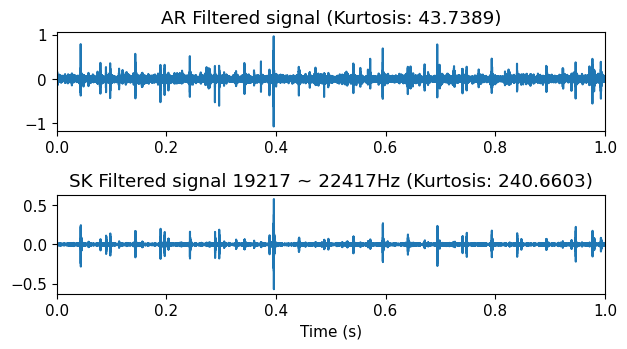

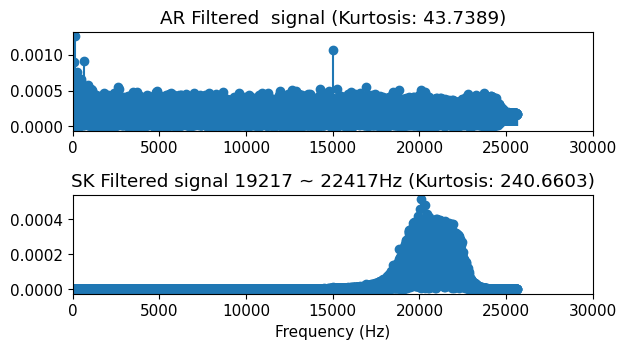

In [7]:
# Comparison of Before and After SK Filtering
cf = 20816.7; bandwith = 3200

def bandpass(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], 'bandpass')
    y = lfilter(b, a, data, axis=0)
    return y

xx1 = bandpass(xr, cf-bandwith/2, cf+bandwith/2, fs, 4); k1 = kurtosis(xx1, fisher=False)

# Time domain signal
plt.figure(2)
plt.subplot(311); plt.plot(t, xr); plt.xlim(0,1); plt.title(f'AR Filtered signal (Kurtosis: {kurtosis(xr, fisher=False):.4f})')
plt.subplot(312); plt.plot(t, xx1); plt.xlim(0,1)
plt.title(f'SK Filtered signal {cf-bandwith/2:.0f} ~ {cf+bandwith/2:.0f}Hz (Kurtosis: {k1:.4f})')
plt.xlabel('Time (s)')
plt.tight_layout()

# Frequency domain signal
X = np.abs(fft(xr))/N; X = X[0:math.ceil(N/2)]
X1 = np.abs(fft(xx1))/N; X1 = X1[0:math.ceil(N/2)]
plt.figure(3)
plt.subplot(311); plt.stem(f, X, basefmt=" "); plt.xlim(0, 3e4)
plt.title(f'AR Filtered  signal (Kurtosis: {kurtosis(xr, fisher=False):.4f})')
plt.subplot(312); plt.stem(f, X1, basefmt=" "); plt.xlim(0, 3e4)
plt.title(f'SK Filtered signal {cf-bandwith/2:.0f} ~ {cf+bandwith/2:.0f}Hz (Kurtosis: {k1:.4f})')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Bandpassed signal')

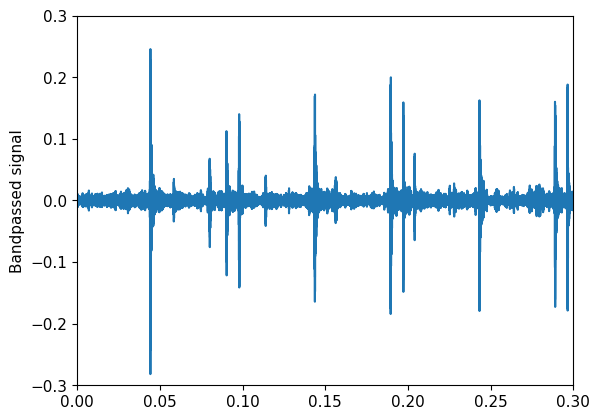

In [8]:
## 3. Signal Demodulation: Envelope Analysis
# Bandpass filtered signal
plt.figure(1)
plt.plot(t, xx1); plt.xlim(0, 0.3); plt.ylim(-0.3, 0.3)
plt.ylabel('Bandpassed signal')

Text(0.5, 1.0, 'Bandpass filtered signal')

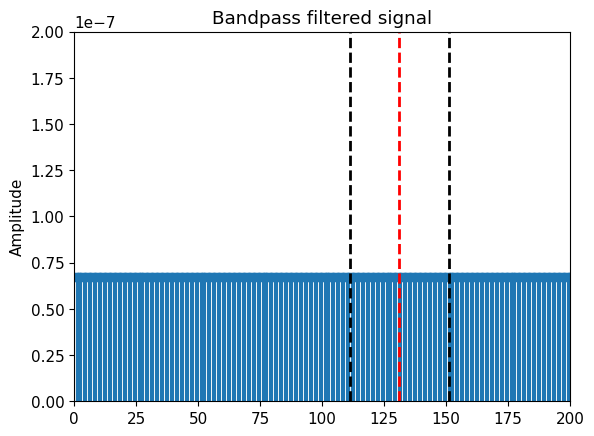

In [9]:
# FFT of signal
plt.figure(2)
plt.stem(f, X1, basefmt=" "); plt.xlim(0, 200)
plt.axvline(bff[1]-fr, c='k', ls='--', linewidth=2); plt.axvline(bff[1], c='r', ls='--', linewidth=2)
plt.axvline(bff[1]+fr, c='k', ls='--', linewidth=2)
plt.ylim(0, 2e-7); plt.ylabel('Amplitude')
plt.title("Bandpass filtered signal")

Text(0.5, 1.0, 'Bandpass filtered and Envelope Signal')

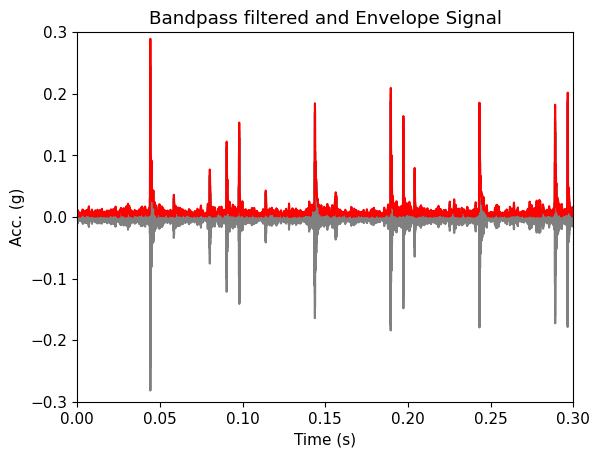

In [10]:
# Scale-up view in (0,200) Hz of (b) <Figure 6(c)>
xn = np.abs(hilbert(xx1))
plt.figure(3)
plt.plot(t, xx1, c = 'gray'); plt.plot(t, xn, 'r')
plt.xlim(0, 0.3); plt.ylim(-0.3, 0.3)
plt.ylabel('Acc. (g)'); plt.xlabel("Time (s)")
plt.title("Bandpass filtered and Envelope Signal")

Text(0, 0.5, 'Amplitude')

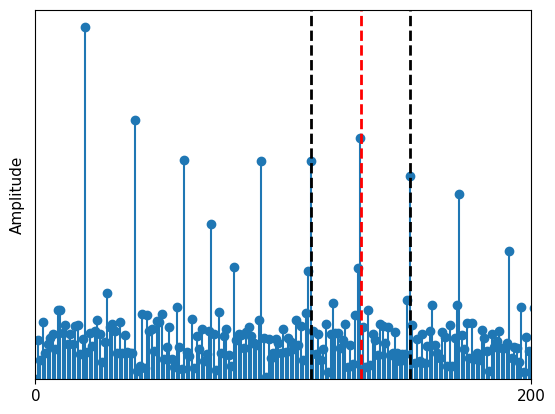

In [11]:
# envelope of signal (a) <Figure 6(d)>
X2 = np.abs(fft(xn-np.mean(xn)))/N; X2 = X2[0:math.ceil(N/2)]
plt.figure(4)
plt.stem(f, X2, basefmt=" "); plt.xticks([0, 200], labels=['0', '200']); plt.xlim(0, 200)
plt.axvline(bff[1]-fr, c='k', ls='--', linewidth=2); plt.axvline(bff[1], c='r', ls='--', linewidth=2)
plt.axvline(bff[1]+fr, c='k', ls='--', linewidth=2)
plt.yticks([]); plt.ylim(0,); plt.ylabel('Amplitude')

Text(0.5, 1.0, 'Bandpass filtered signal')

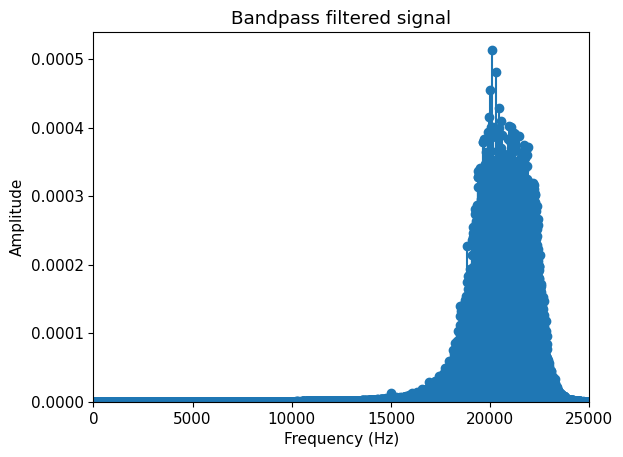

In [12]:
# FFT of envelope signal (d) <Figure 6(e)>
plt.figure(5)
plt.stem(f, X1, basefmt=" "); plt.xlim(0, 2.5e4)
plt.ylim(0,); plt.ylabel('Amplitude'); plt.xlabel("Frequency (Hz)")
plt.title("Bandpass filtered signal")

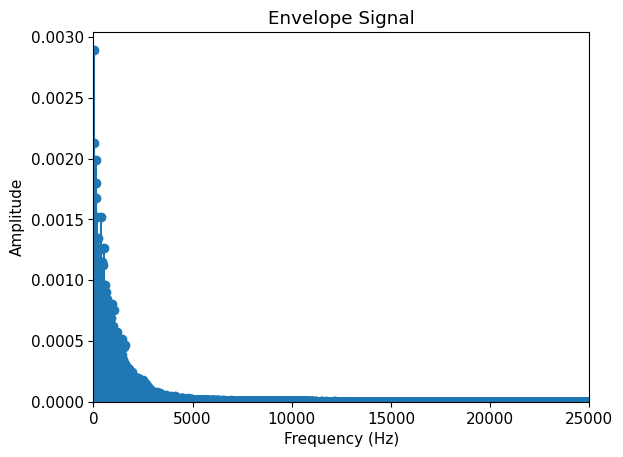

In [13]:
# Scale-up view in(0,200)Hz of (f) <Figure 6(e)>
plt.figure(6)
plt.stem(f, X2, basefmt=" "); plt.xlim(0, 2.5e4)
plt.ylim(0,); plt.ylabel('Amplitude'); plt.xlabel("Frequency (Hz)")
plt.title("Envelope Signal")
plt.show()

In [15]:
## 4. Signal Decomposition: EMD
from PyEMD import EMD

emd = EMD(MAX_ITERATION=100, energy_ratio=20)
imf = emd.emd(x, max_imf=10)
XX = np.zeros([11, math.ceil(N/2)])
for ix in range(11):
    tmp = abs(fft(imf[ix]))/N; tmp = tmp[0:math.ceil(N/2)]
    XX[ix] = tmp


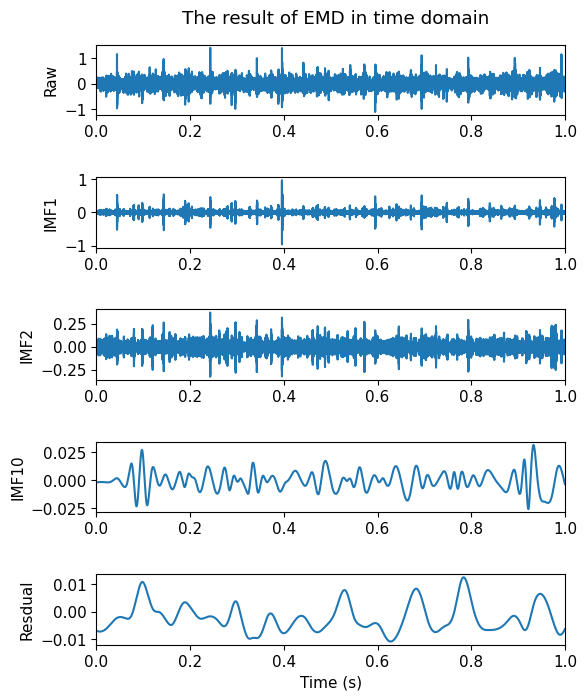

In [17]:
# Time domain signal <Figure 7(a)>
plt.figure(1, figsize=[6, 8])
plt.subplot(611); plt.plot(t, x); plt.ylabel('Raw'); plt.xlim(0, 1)
plt.subplot(612); plt.plot(t, imf[0]); plt.ylabel('IMF1'); plt.xlim(0, 1)
plt.subplot(613); plt.plot(t, imf[1]); plt.ylabel('IMF2'); plt.xlim(0, 1)
plt.subplot(614); plt.plot(t, imf[9]); plt.ylabel('IMF10'); plt.xlim(0, 1)
plt.subplot(615); plt.plot(t, imf[-1]); plt.ylabel('Resdual'); plt.xlim(0, 1)
plt.xlabel('Time (s)')
plt.suptitle('The result of EMD in time domain', x=0.57)
plt.tight_layout()

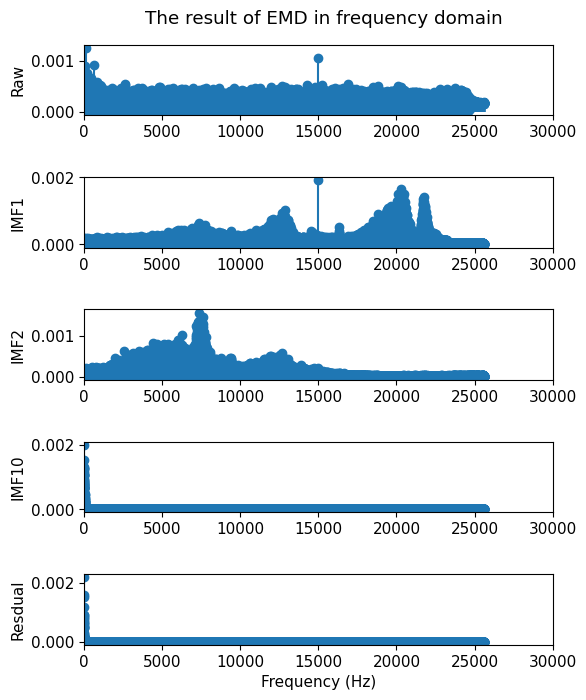

In [19]:
# Frequency domain signal <Figure 7(b)>
plt.figure(2, figsize=[6, 8])
plt.subplot(611); plt.stem(f, X, basefmt=" "); plt.ylabel('Raw'); plt.xlim(0, 3e4)
plt.subplot(612); plt.stem(f, XX[0], basefmt=" "); plt.ylabel('IMF1'); plt.xlim(0, 3e4)
plt.subplot(613); plt.stem(f, XX[1], basefmt=" "); plt.ylabel('IMF2'); plt.xlim(0, 3e4)
plt.subplot(614); plt.stem(f, XX[9], basefmt=" "); plt.ylabel('IMF10'); plt.xlim(0, 3e4)
plt.subplot(615); plt.stem(f, XX[-1], basefmt=" "); plt.ylabel('Resdual'); plt.xlim(0, 3e4)
plt.xlabel('Frequency (Hz)')
plt.suptitle('The result of EMD in frequency domain', x=0.55)
plt.tight_layout()
plt.show()